# Modeling and Simulation in Python

Chapter 7: 

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


We'll start with the same code we saw last time: the magic command that tells Jupyter where to put the figures, and the import statement that gets the function defined in the `modsim` module.

In [1]:
# If you want the figures to appear in the notebook, 
# and you want to interact with them, use
# %matplotlib notebook

# If you want the figures to appear in the notebook, 
# and you don't want to interact with them, use
# %matplotlib inline

# If you want the figures to appear in separate windows, use
# %matplotlib qt|

# tempo switch from one to another, you have to select Kernel->Restart

%matplotlib inline

from modsim import *

In [40]:
init = State(temp=90)
init

,value
temp,90


In [41]:
coffee = System(init=init, T_env=22, r=0.01, t0=0, t_end=30)
coffee

,value
init,temp 90 dtype: int64
T_env,22
r,0.01
t0,0
t_end,30


In [42]:
def update(system, state):
    """Update the thermal transfer model.
    
    system: System object
    state: State (temp)
    
    returns: State (temp)
    """
    T = state.temp
    T = T - system.r * (T - system.T_env)
    return State(temp=T)

In [43]:
update(coffee, init)

,value
temp,89.32


In [44]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
    
    Add a DataFrame to the System: results
    
    system: System object
    update_func: function that updates state
    """
    df = TimeFrame(columns=system.init.index)
    df.loc[system.t0] = system.init
    
    for i in range(system.t0, system.t_end):
        df.loc[i+1] = update_func(system, df.loc[i])
    
    system.results = df

In [45]:
run_simulation(coffee, update)
coffee.results

,temp
0,90
1,89.32
2,88.6468
3,87.9803
4,87.3205
5,86.6673
6,86.0207
7,85.3804
8,84.7466
9,84.1192


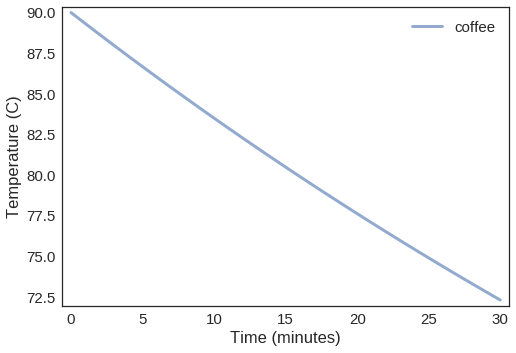

In [47]:
plot(coffee.results.temp, label='coffee')
decorate(xlabel='Time (minutes)',
         ylabel='Temperature (C)')

In [10]:
def final_temp(system):
    """Final temperature.
    
    system: System object with results.
    
    returns: temperature (C)
    """
    # TODO: if there are no results, return init.temp? 
    df = system.results
    return df.temp[system.t_end]

In [11]:
def run(volume, temp_init, r, t_end):
    init = State(temp=temp_init)
    system = System(volume=volume, init=init, T_env=22, 
                    r=r, t0=0, t_end=t_end)
    run_simulation(system, update)
    return system

In [12]:
coffee = run(volume=300, temp_init=90, r=0.01, t_end=30)
final_temp(coffee)

72.2996253904031

In [52]:
def func(x):
    return (x-1) * (x-2) * (x-3)

In [64]:
fsolve(func, x0=0)

array([ 1.])

In [57]:
fsolve(func, 1.9)

array([ 2.])

In [58]:
fsolve(func, 2.9)

array([ 3.])

In [63]:
fsolve(func, 1.5)

array([ 3.])

In [13]:
def error_func1(r):
    """Runs a simulation and returns the `error`.
    
    r: thermal insulation factor
    
    returns: difference between final temp and 70C
    """
    system = run(volume=300, temp_init=90, r=r, t_end=30)
    return final_temp(system) - 70

In [14]:
error_func1(r=0.01)

2.2996253904030937

In [15]:
solution = fsolve(error_func1, 0.01)
r_coffee = solution[0]
r_coffee

0.011543084583973956

In [16]:
coffee = run(volume=300, temp_init=90, r=r_coffee, t_end=30)
final_temp(coffee)

70.0000000000064

**Exercise:**

In [17]:
milk = run(volume=50, temp_init=5, r=0.1, t_end=15)
final_temp(milk)

18.499850754390966

In [18]:
def error_func2(r):
    """Runs a simulation and returns the `error`.
    
    r: thermal insulation factor
    
    returns: difference between final temp and 20C
    """
    system = run(volume=50, temp_init=5, r=r, t_end=15)
    return final_temp(system) - 20

In [19]:
error_func2(r=0.1)

-1.500149245609034

In [20]:
solution = fsolve(error_func2, 0.1)
r_milk = solution[0]
r_milk

0.13296078935465339

In [21]:
milk = run(volume=50, temp_init=5, r=r_milk, t_end=15)
final_temp(milk)

19.999999999999613

In [34]:
milk = run(volume=50, temp_init=5, r=r_milk, t_end=30)
final_temp(milk)

21.76470588235285

Saving figure to file chap07-fig01.pdf


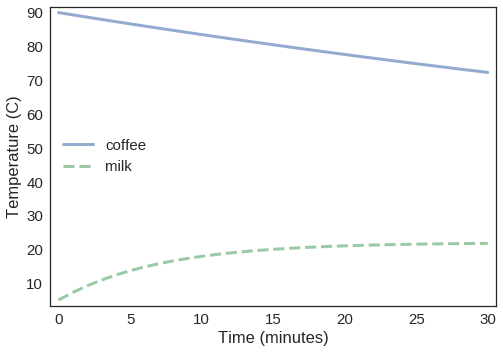

In [66]:
plot(coffee.results.temp, label='coffee')
plot(milk.results.temp, '--', label='milk')
decorate(xlabel='Time (minutes)',
         ylabel='Temperature (C)',
         loc='center left')

savefig('chap07-fig01.pdf')

In [69]:
from sympy import symbols, Eq, solve

C1, C2, T1, T2, T = symbols('C1 C2 T1 T2 T')

eq = Eq(C1 * (T - T1) + C2 * (T - T2), 0)

solve(eq, T)

[(C1*T1 + C2*T2)/(C1 + C2)]

In [23]:
def mix(s1, s2):
    assert s1.t_end == s2.t_end
    
    volume = s1.volume + s2.volume
    
    temp = (s1.volume * final_temp(s1) + 
            s2.volume * final_temp(s2)) / volume
    
    init = State(temp=temp)
    mixture = System(volume=volume, init=init, T_env=22, 
                    r=s1.r, t0=s1.t_end, t_end=30)
    
    return mixture

In [24]:
mix_last = mix(coffee, milk)
mix_last.init.temp

63.109243697484459

In [25]:
coffee = run(volume=300, temp_init=90, r=r_coffee, t_end=1)
milk = run(volume=50, temp_init=5, r=r_milk, t_end=1)
mix_first = mix(coffee, milk)
mix_first.init.temp

77.507250701252545

In [26]:
run_simulation(mix_first, update)
final_temp(mix_first)

61.639146754120532

In [27]:
def run_and_mix(t_add):
    coffee = run(volume=300, temp_init=90, r=r_coffee, t_end=t_add)
    milk = run(volume=50, temp_init=5, r=r_milk, t_end=t_add)
    mixture = mix(coffee, milk)
    run_simulation(mixture, update)
    return final_temp(mixture)

In [28]:
run_and_mix(1)

61.639146754120532

In [29]:
run_and_mix(15)

62.902809128457783

In [30]:
run_and_mix(30)

63.109243697484459

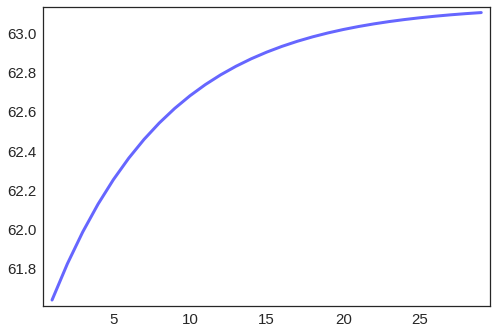

In [31]:
for t_add in range(1, 30):
    temp = run_and_mix(t_add)
    plot(t_add, temp, 'b-')